This is a continuation of the exploration of the real estate data set on python. The key is to explore and become so familiar with the APIs that it becomes a second nature

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
#import xgboost as xgb # <-Couldn't install for a long time tried and tried. May need to come back to this later

In [7]:
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [8]:
# Set up the python data frame display options
pd.options.display.max_rows=1000
pd.options.display.max_columns=20

In [9]:
fname="../Python EDA/train.csv"
fname1="../Python EDA/test.csv"
train=pd.read_csv(fname)
test=pd.read_csv(fname1)

In [15]:
#separating the quantitative from the qualittative. These are just column names
quantitative=[f for f in train.columns if train.dtypes[f]!='object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative=[f for f in train.columns if train.dtypes[f]=='object']

In [18]:
#Looking at the quantitative and qualitative data sets
print(quantitative)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [19]:
print(qualitative)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


# Missing Data

In [25]:
missing=train.isnull().sum()
#train.isnull() #<-this returns boolean value on the input dataframe

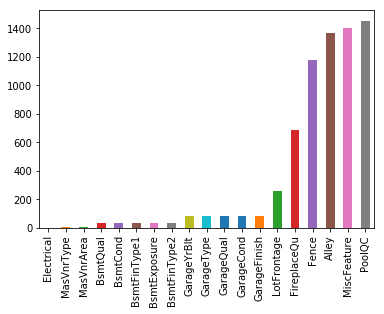

In [27]:
missing=missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar();

In [43]:
a=[round(f/len(train),2) for f in missing] #<-this doesn't retain the name of the column
a 

[0.0,
 0.01,
 0.01,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.06,
 0.06,
 0.06,
 0.06,
 0.06,
 0.18,
 0.47,
 0.81,
 0.94,
 0.96,
 1.0]

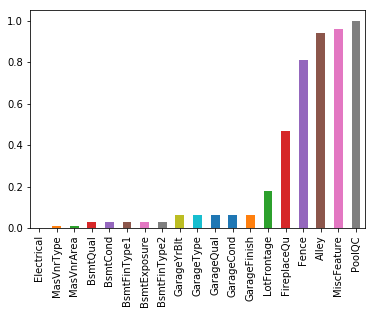

In [48]:
round(missing/len(train),2).plot.bar();

# Key take away from above:
19 attributes have missing values, 5 over 50% of all data. Most of times NA means lack of subject described by attribute, like missing pool, fence, no garage and basement.

# Qualitative Data

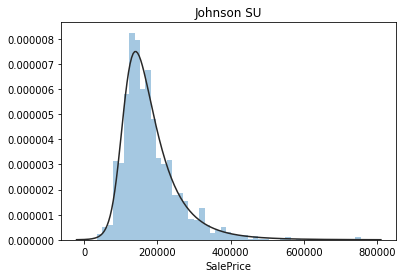

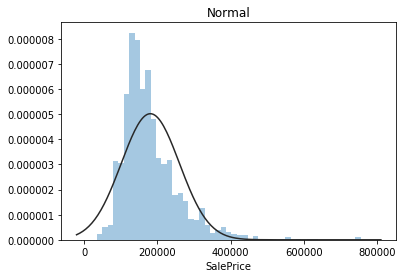

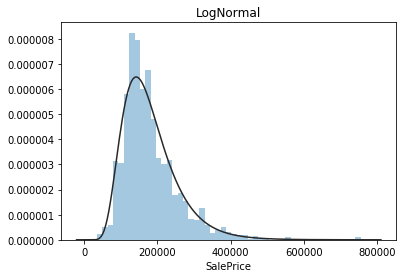

In [54]:
import scipy.stats as st
#Notice that the fit parameter passed to the sns plot 
#KDE parameter is passed to Whether to plot a gaussian kernel density estimate.
y=train['SalePrice']
plt.figure(1);plt.title("Johnson SU")
sns.distplot(y,kde=False,fit=st.johnsonsu);
plt.figure(2);plt.title("Normal")
sns.distplot(y,kde=False,fit=st.norm);
plt.figure(3);plt.title("LogNormal")
sns.distplot(y,kde=False,fit=st.lognorm);

It is apparent that SalePrice doesn't follow normal distribution, so before performing regression it has to be transformed. While log transformation does pretty good job, best fit is unbounded Johnson distribution.

In [55]:
test_normality=lambda x:stats.shapiro(x.fillna(0))[1]<0.01 #stores a lambda function
normal=pd.DataFrame(train[quantitative])

In [56]:
test_normality

<function __main__.<lambda>>

In [57]:
normal=normal.apply(test_normality)
normal

MSSubClass       True
LotFrontage      True
LotArea          True
OverallQual      True
OverallCond      True
YearBuilt        True
YearRemodAdd     True
MasVnrArea       True
BsmtFinSF1       True
BsmtFinSF2       True
BsmtUnfSF        True
TotalBsmtSF      True
1stFlrSF         True
2ndFlrSF         True
LowQualFinSF     True
GrLivArea        True
BsmtFullBath     True
BsmtHalfBath     True
FullBath         True
HalfBath         True
BedroomAbvGr     True
KitchenAbvGr     True
TotRmsAbvGrd     True
Fireplaces       True
GarageYrBlt      True
GarageCars       True
GarageArea       True
WoodDeckSF       True
OpenPorchSF      True
EnclosedPorch    True
3SsnPorch        True
ScreenPorch      True
PoolArea         True
MiscVal          True
MoSold           True
YrSold           True
dtype: bool

Also none of quantitative variables has normal distribution so these should be transformed as well.

In [58]:
f=pd.melt(train,value_vars=quantitative)
#The melt function turns the wide datatable into a long table

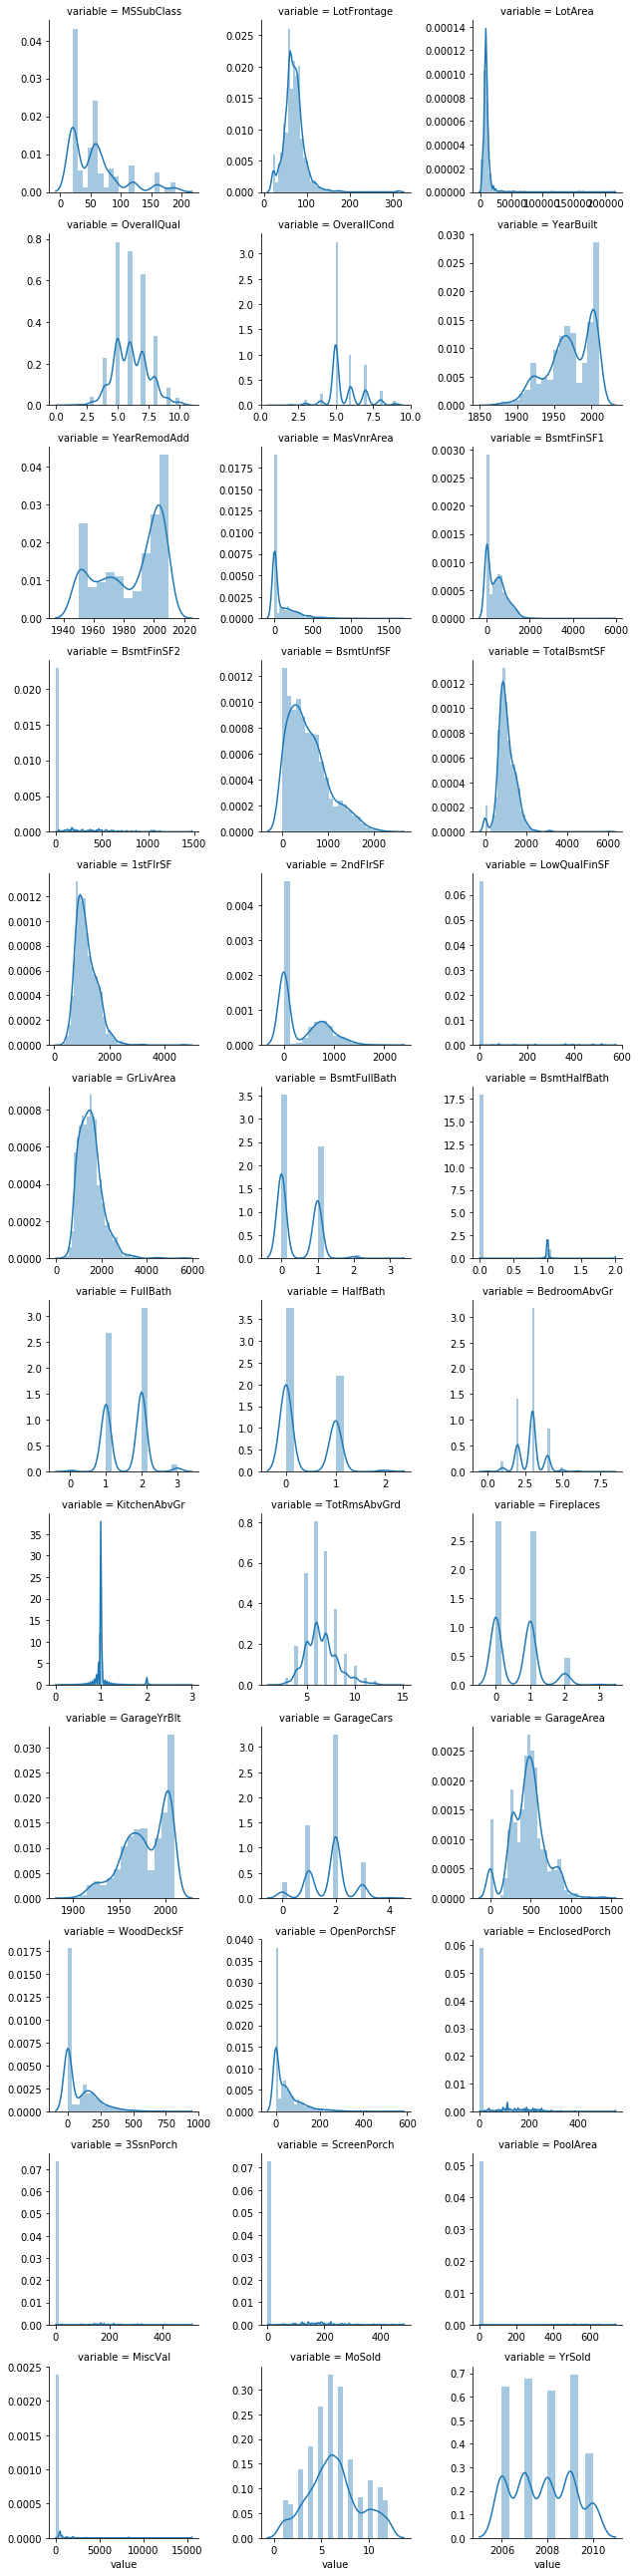

In [61]:
g=sns.FacetGrid(f,col="variable",col_wrap=3,sharex=False,sharey=False)
g=g.map(sns.distplot,"value")

Some independent variables look like good candidates for log transformation: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea and others. While ganining on regression transformation will smooth out some irregularities which could be important like large amount of houses with 0 2ndFlrSF. Such irregularities are good candidates for feature construction.

# Categorical data 
with qualitative variables we can implement two methods, first one is to check distribution of SalePrice with respective to variable values and enumerate them. Second to create dummy variable for each possible category

In [63]:
# First transform them into default category data type
#Second filla the missing values with missing value as a new value category
for c in qualitative: 
    train[c]=train[c].astype("category")
    if train[c].isnull().any():
        train[c]=train[c].cat.add_categories(["MISSING"])
        train[c]=train[c].fillna("MISSING")

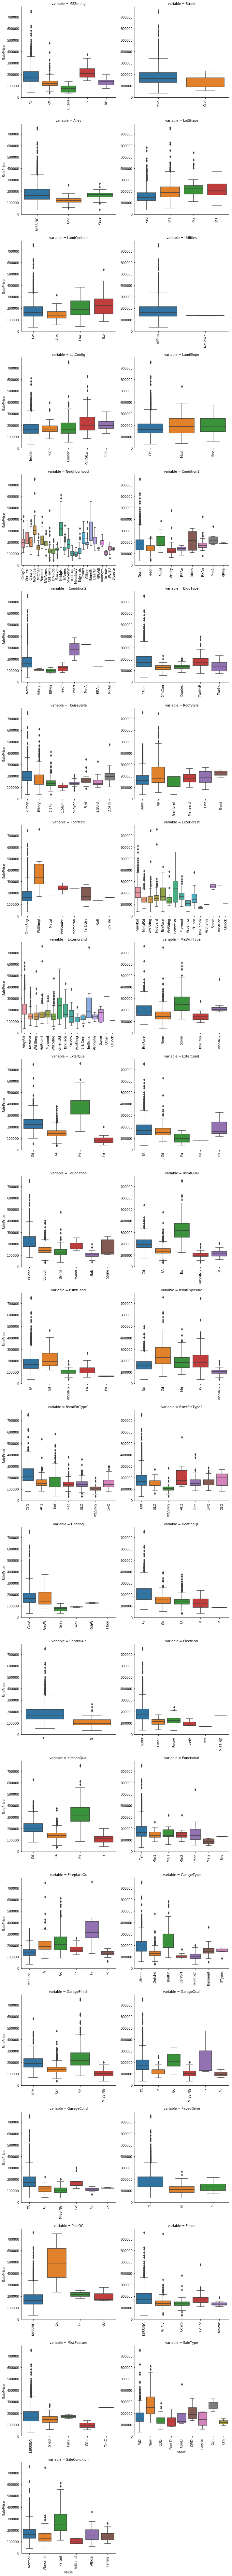

In [71]:
#Define a function to apply all the necessary transformation on the graphs
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    x=plt.xticks(rotation=90)
#make saleprice the value and the variables the categories
f=pd.melt(train,id_vars=["SalePrice"],value_vars=qualitative)
#Set the grid on top of which the graphs are plotted over
g=sns.FacetGrid(f,col='variable',col_wrap=2,sharex=False,sharey=False,size=5)
#Plot the graphs as box graphs using the mapping function
g=g.map(boxplot,"value","SalePrice")

In [66]:
f

SalePrice       variable    value
0         208500       MSZoning       RL
1         181500       MSZoning       RL
2         223500       MSZoning       RL
3         140000       MSZoning       RL
4         250000       MSZoning       RL
5         143000       MSZoning       RL
6         307000       MSZoning       RL
7         200000       MSZoning       RL
8         129900       MSZoning       RM
9         118000       MSZoning       RL
10        129500       MSZoning       RL
11        345000       MSZoning       RL
12        144000       MSZoning       RL
13        279500       MSZoning       RL
14        157000       MSZoning       RL
15        132000       MSZoning       RM
16        149000       MSZoning       RL
17         90000       MSZoning       RL
18        159000       MSZoning       RL
19        139000       MSZoning       RL
20        325300       MSZoning       RL
21        139400       MSZoning       RM
22        230000       MSZoning       RL
23        129900       MSZoning       RM
24        154000       MSZoning       RL
25        256300       MSZoning       RL
26        134800       MSZoning       RL
27        306000       MSZoning       RL
28        207500       MSZoning       RL
29         68500       MSZoning       RM
30         40000       MSZoning  C (all)
31        149350       MSZoning       RL
32        179900       MSZoning       RL
33        165500       MSZoning       RL
34        277500       MSZoning       RL
35        309000       MSZoning       RL
36        145000       MSZoning       RL
37        153000       MSZoning       RL
38        109000       MSZoning       RL
39         82000       MSZoning       RL
40        160000       MSZoning       RL
41        170000       MSZoning       RL
42        144000       MSZoning       RL
43        130250       MSZoning       RL
44        141000       MSZoning       RL
45        319900       MSZoning       RL
46        239686       MSZoning       RL
47        249700       MSZoning       FV
48        113000       MSZoning       RM
49        127000       MSZoning       RL
50        177000       MSZoning       RL
51        114500       MSZoning       RM
52        110000       MSZoning       RM
53        385000       MSZoning       RL
54        130000       MSZoning       RL
55        180500       MSZoning       RL
56        172500       MSZoning       FV
57        196500       MSZoning       RL
58        438780       MSZoning       RL
59        124900       MSZoning       RL
60        158000       MSZoning       RL
61        101000       MSZoning       RM
62        202500       MSZoning       RL
63        140000       MSZoning       RM
64        219500       MSZoning       RL
65        317000       MSZoning       RL
66        180000       MSZoning       RL
67        226000       MSZoning       RL
68         80000       MSZoning       RM
69        225000       MSZoning       RL
70        244000       MSZoning       RL
71        129500       MSZoning       RL
72        185000       MSZoning       RL
73        144900       MSZoning       RL
74        107400       MSZoning       RM
75         91000       MSZoning       RM
76        135750       MSZoning       RL
77        127000       MSZoning       RM
78        136500       MSZoning       RL
79        110000       MSZoning       RM
80        193500       MSZoning       RL
81        153500       MSZoning       RM
82        245000       MSZoning       RL
83        126500       MSZoning       RL
84        168500       MSZoning       RL
85        260000       MSZoning       RL
86        174000       MSZoning       RL
87        164500       MSZoning       FV
88         85000       MSZoning  C (all)
89        123600       MSZoning       RL
90        109900       MSZoning       RL
91         98600       MSZoning       RL
92        163500       MSZoning       RL
93        133900       MSZoning  C (all)
94        204750       MSZoning       RL
95        185000       MSZoning       RL
96        214000       MSZonin

Some categories seem to more diverse with respect to SalePrice than others. Neighborhood has big impact on house prices. Most expensive seems to be Partial SaleCondition. Having pool on property seems to improve price substantially. There are also differences in variabilities between category values.

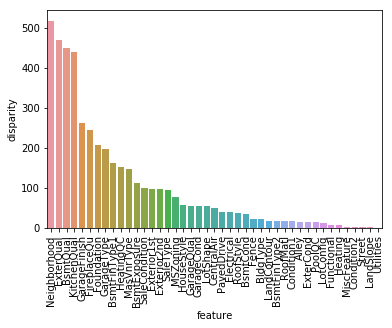

In [72]:
def anova(frame):
    anv=pd.DataFrame()
    anv['feature']=qualitative
    pvals=[]
    for c in qualitative:
        samples=[]
        for cls in frame[c].unique():
            s=frame[frame[c]==cls]["SalePrice"].values
            samples.append(s)
        pval=stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval']=pvals
    return anv.sort_values('pval')

a=anova(train)
a['disparity']=np.log(1./a['pval'].values)
sns.barplot(data=a,x="feature",y="disparity")
x=plt.xticks(rotation=90)

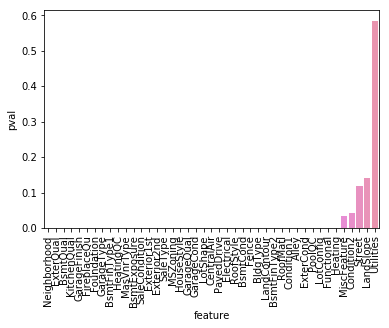

In [78]:
sns.barplot(data=a,y='pval',x='feature');
x=plt.xticks(rotation=90)

Here is quick estimation of influence of categorical variable on SalePrice. For each variable SalePrices are partitioned to distinct sets based on category values. Then check with ANOVA test if sets have similar distributions. If variable has minor impact then set means should be equal. Decreasing pval is sign of increasing diversity in partitions.

In [79]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


# Correlations
Generally to reduce confunding only variables uncorrelated with each other should be added to regression models (which are correlated with SalePrice).

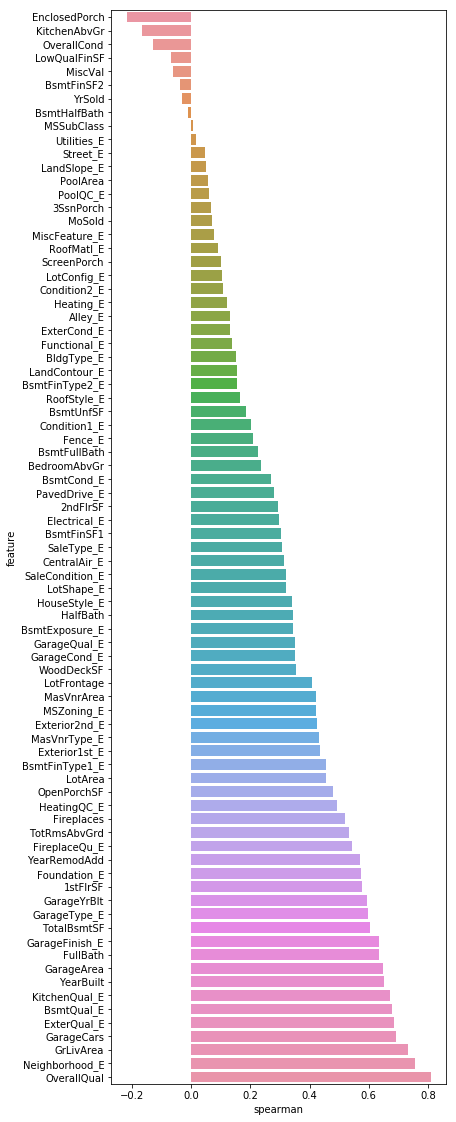

In [83]:
#This is to write a function of quickly finding correlations between
#other varialbes and the the saleprice variable 
#Eventually outputting the bar chart of negative and positive correlations 
def spearman(frame,features):
    spr=pd.DataFrame()
    spr['feature']=features
    spr['spearman']=[frame[f].corr(frame['SalePrice'],'spearman') for f in features]
    spr=spr.sort_values("spearman")
    plt.figure(figsize=(6,0.25*len(features)))
    sns.barplot(data=spr,y="feature",x="spearman",orient="h")
    
features=quantitative+qual_encoded
spearman(train,features)


Spearman correlation is better to work with in this case because it picks up relationships between variables even when they are nonlinear. OverallQual is main criterion in establishing house price. Neighborhood has big influence, partially it has some intrisinc value in itself, but also houses in certain regions tend to share same characteristics (confunding) what causes similar valuations.

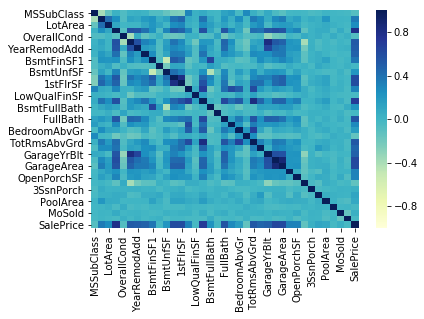

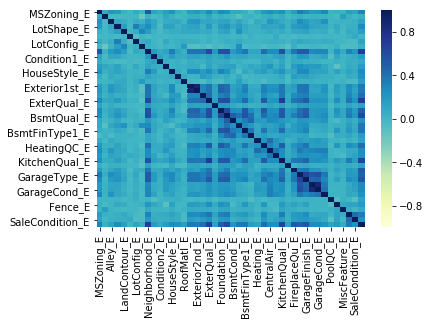

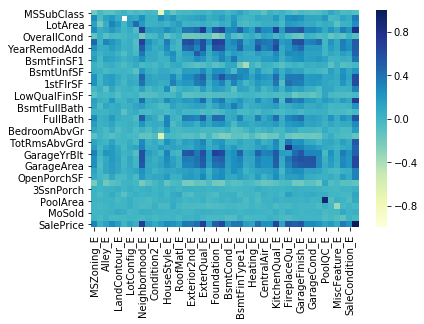

In [92]:
#Looking at the heatmap plotting of the all correlations
plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()
sns.heatmap(corr,cmap="YlGnBu",vmin=-1,vmax=1)
plt.figure(2)
corr = train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr,cmap="YlGnBu",vmin=-1,vmax=1)
plt.figure(3)
#Still not suare of what the encoded variables mean here
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr,cmap="YlGnBu",vmin=-1,vmax=1);

# pairplots
it also would be useful to see how sale price compares to each independent variable

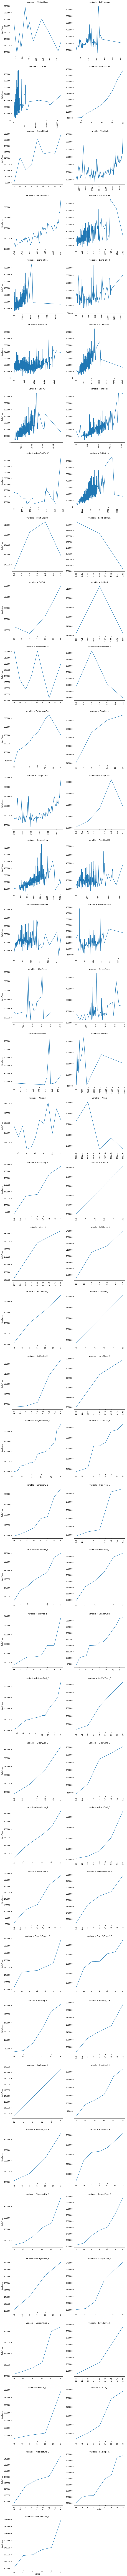

In [94]:
#Again define a function to 
def pairplot(x,y,**kwargs):
    ax=plt.gca()
    ts=pd.DataFrame({'time':x,'val':y})
    ts=ts.groupby("time").mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f=pd.melt(train,id_vars=['SalePrice'],value_vars=quantitative+qual_encoded)
g=sns.FacetGrid(f,col="variable",col_wrap=2,sharex=False,sharey=False,size=5)
g=g.map(pairplot,"value","SalePrice")

There are lots of nonlinearities this may be the cause why some variables wont be selected by Lasso/Lars. Some factors like YearBuilt, 1stFlrSF, 2ndFlrSF, Neighborhood_E look like they would benefit from adding quadratic term to regression. But on the other hand this will most probably provoke overfit.